# Data Analysis

Initial investigation of open datasets provided by Edmonton Open Data. Main processes for analysis are trial and error ensuring optimized datatypes and spot checking missing values, both within the dataset and through mapping tools like Google Maps.

In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# [Property Assessment 2018](https://data.edmonton.ca/City-Administration/Property-Assessment-Data-Current-Calendar-Year-/q7d6-ambg)
- `nb` stands for neighbourhood
- The `ward` column is dropped from the DataFrame
    - The ward information is not understandable by the average homeowner

### Set the correct data types for each of the remaining columns and reorder columns

In [2]:
# set column names that are intuitive, standardized, and callable as DataFrame attributes
col_names = ['acc_num', 'suite', 'number', 'street', 'value', 'class', 
             'nb_id', 'nb', 'ward', 'garage', 'lat', 'long']

# set column datatypes
col_dtypes = {'acc_num':np.int32, 'suite':object, 'number':object, 'street':object, 
              'value':np.int32, 'class':'category', 'nb':'category'}

# set the column order
col_keep = ['acc_num', 'nb', 'nb_id', 'class', 'value', 'suite', 'number', 'street',
            'garage', 'lat', 'long']

# import the csv data into a DataFrame: df
df = pd.read_csv('Property_Assessment_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, 
                 true_values='Y', false_values='N')[col_keep]

# [Property Information 2018](https://data.edmonton.ca/City-Administration/Property-Information-Data-Current-Calendar-Year-/dkk9-cj3x)

- Only the `account number`, `zoning`, `lot size`, `year built`, and `neighbourhood` columns are kept in the DataFrame.
- This data will be used to filter the final cleaned DataFrame, and
- Inform the predictive model for Machine Learning

In [3]:
# set column names that are intuitive, standardized, and callable as DataFrame attributes
col_names = ['acc_num', 'suite', 'number', 'street', 'legal_desc', 'zoning', 
             'lot_size', 'year_built', 'nb_id', 'nb', 'ward', 'lat', 'long']

# set column datatypes
col_dtypes = {'acc_num':np.int32, 'zoning':object, 'lot_size':object, 'year_built':object}

# set the column order
col_keep = ['acc_num', 'zoning', 'lot_size', 'year_built', 'nb']

# import the csv data into a DataFrame: df_info
df_info = pd.read_csv('Property_Information_Data__Current_Calendar_Year_.csv', 
                 header=0, names=col_names, dtype=col_dtypes, low_memory=False)[col_keep]

### Remove and verify the number of null neighbourhood ID records
- This dataset contains one record without a neighbourhood ID
    - This record has a substantially lower property assessment value
    - This record represents an outlier in the nearly 400,000 records because it lacks significantly more data than is required to make any informed analysis

In [4]:
# generate a DataFrame of the neighbourhood null records from: df
df_null = df[df.nb.isnull()]

# generate a DataFrame of the neighbourhood null records from: df_info
df_info_null = df_info[df_info.nb.isnull()]

# generate a DataFrame (df_cleaned) without the null record
df_cleaned = df[~df.nb.isnull()]

# generate a DataFrame (df_info_cleaned) without the null record
df_info_cleaned = df_info[~df_info.nb.isnull()]

# print the number of null records for each DataFrame
print('The number of null neighbourhood records in df = {}'.format(len(df_null)))
print('The number of null neighbourhood records in df_info = {}'.format(len(df_info_null)))

The number of null neighbourhood records in df = 1
The number of null neighbourhood records in df_info = 1


## Merge the `assessment` and `info` DataFrames

### Filter the data for only the residential entries. To eliminate large malls, high-rises, parks, walkways, and other entries that do not inform residential property assessments.

**It has been found through exploratory data analysis that residential `zonings` are more reliable than the City's `class` designators**
    - These two variables will be used in conjunction to filter the best possible set of residential property assessments.

In [5]:
df_info_cleaned = df_info_cleaned[['acc_num', 'zoning', 'lot_size', 'year_built']]

# merge the two non-null DataFrames on the account number: df_clean
df_clean = df_cleaned.merge(df_info_cleaned, on='acc_num')

# prepare the zoning column for filtering by filling null values with an empty string
df_clean['zoning'] = df_clean['zoning'].fillna('')

# filter the indexes for zonings that contain R. These are found to be all residential
df_index = df_clean.zoning.str.contains('R')
df_clean = df_clean[df_index]

# also filter the DataFrame on the Residential class
df_clean = df_clean[df_clean['class'] == 'Residential']

# filter the Dataframe for values between $20,000 and $10,000,000
df_clean = df_clean[df_clean['value'] > 20000]
df_clean = df_clean[df_clean['value'] < 10000000]

## Missing street data is also found to be indicative of inconsequential records
- Any lookup system would be reliant on accurate street data for indentification of the property
- Many of these records have significantly low or high valuations (on Google Maps, these locations seem to be research facilites, walkways, signage, community buildings, etc.)

In [6]:
# generate a DataFrame of all the null street entries
df_street_null = df_clean[df_clean.street.isnull()]

# update the df_clean DataFrame to exclude the missing street entries
df_clean = df_clean[~df_clean.street.isnull()]

# print the number of entries that have missing street data
print('The number of null street records in df_clean = {}'.format(len(df_street_null)))

The number of null street records in df_clean = 205


# [Edmonton Criminal Incidents by Neibourhood](https://dashboard.edmonton.ca/dataset/EPS-Neighbourhood-Criminal-Incidents/xthe-mnvi)
- Data is pulled from City of Edmonton Open Data portal.
- The two data frames will be joined on `nb` neighbourhood name.

### Rename the columns more logically and to align with `df_cleaned`

In [7]:
# set column names that are intuitive, standardized, and callable as DataFrame attributes
col_list = ['nb', 'violation', 'year', 'quarter', 'month', 'num_incidents']

# set column datatypes
col_dtypes = {'nb':'category', 'violation':'category', 'year':str, 'month':str}

# set the column order
col_order = ['nb', 'violation', 'num_incidents', 'year', 'month', 'quarter']

# import the csv data into a DataFrame: df_crime
df_crime = pd.read_csv('EPS_Neighbourhood_Criminal_Incidents.csv', header=0, 
                      names=col_list, dtype=col_dtypes)[col_order]

### Convert `year` and `month` to a datetime column

In [8]:
# transform the year and month columns into a concatenated datetime column yyyy-mm
datetime = pd.to_datetime(df_crime['year'] + '-' + df_crime['month'])

# add the datetime column to the df_crime DataFrame
df_crime['record_month'] = datetime

# drop the original year and month columns in favour of the new datatime record_month column
df_crime = df_crime[['nb', 'violation', 'num_incidents', 'record_month']]

# set the index of the crime data to be the newly created datetime index
df_crime.set_index('record_month', inplace=True)

### Splice the crime data for only 2018 to avoid overexposing crime incidents in older neighbourhoods.

In [9]:
# generate a DataFrame: crime2018 for only the current year
crime2018 = df_crime.loc['2018']

# pivot the DataFrame to show the number of incidents for each neighbourhood
# aggregated by the sum for each violation
incidents2018 = crime2018.pivot_table(values='num_incidents', index='nb', 
                                      columns='violation', fill_value=0, aggfunc='sum')

### Merge the two dataframes to generate a complete and cleaned dataset
- Reset the index and drop the old index

- Filter on just the most recent crime data (2018)

In [10]:
# merge df_clean with incidents2018 to generate a DataFrame of all previous processes
property_assess = df_clean.merge(incidents2018, left_on='nb', right_index=True)

# reset the index of the new DataFrame: property_assess
property_assess.reset_index(inplace=True)

# drop the original index from the DataFrame
property_assess.drop('index', axis=1, inplace=True)

# sort the DataFrame from lowest assesement value to greatest
property_assess = property_assess.sort_values(by='value', ascending=True)

In [11]:
# export DataFrame for use in future analysis
property_assess.to_csv('assessment.csv')

### Assessment of property outliers

- Scatter plots
- Spot check extreme values

# Visualization of Residential Assessment Values

What we can see from this figure is the general landscape of the assessment values. The histogram is highly skewed to the right and a logarithmic scale is required to illustrate the sparce representation of residential properties evaluated above 2 million dollars.

We see a spike in the number of assessments valued at and around $500,000 with all histogram bins in that region representing ~10,000 properties. The bins for properties assessed above 2 million dollars are on the order of 1-10 properties.

This figure is not representative of any flaw or salient feature of the assessment process. This histogram more accurately illustrates the wealth gap in Edmonton and displays the range of current assessment values for 2018.

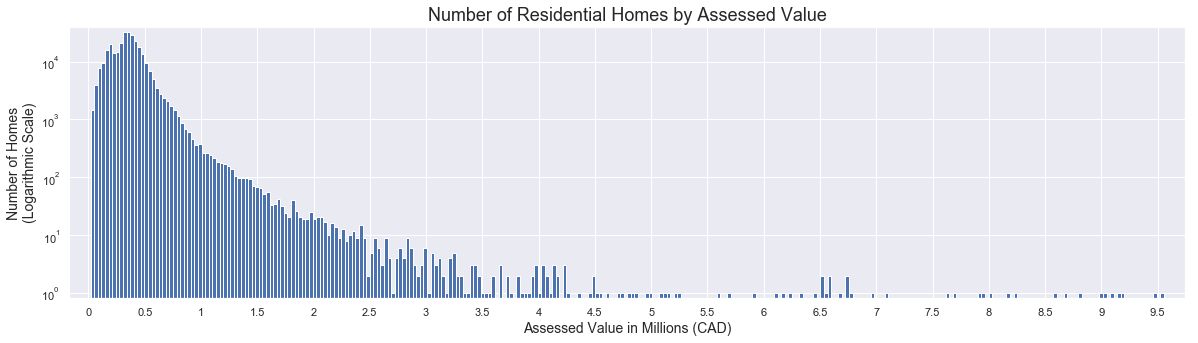

In [12]:
sns.set()
# Generate a plot of residential homes and minimize outliers.
plt.figure(figsize=(20,5))
ax = property_assess['value'].plot(kind='hist', bins=300, logy=True)
ax.set_xlabel('Assessed Value in Millions (CAD)', fontsize=14)
ax.set_xticks([i for i in range(0,10000000,500000)])
ax.set_xticklabels([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10])
ax.set_ylabel('Number of Homes\n(Logarithmic Scale)', fontsize=14)
ax.set_title('Number of Residential Homes by Assessed Value', fontsize=18)
plt.margins(0.02)

plt.show()

# Visualization of Property Zonings

While the following figure is impossible to analze at this resolution and zoom, the exported png was analyzed to see if any of the current property zonings were unnecessary in the subsequential analysis.

Each zoning produces its own stip on the plot and the algorithm plots each property for that zoning along the y-axis, which is the assessment value.

It was found that some zonings have very few properties (CR, EETR) while others represent the vast majority (RF-1 --> RF-7)

All zoning values represent some proportion of Edmonton's residential properties and therefore the current DataFrame is maintained for subsequential analysis.

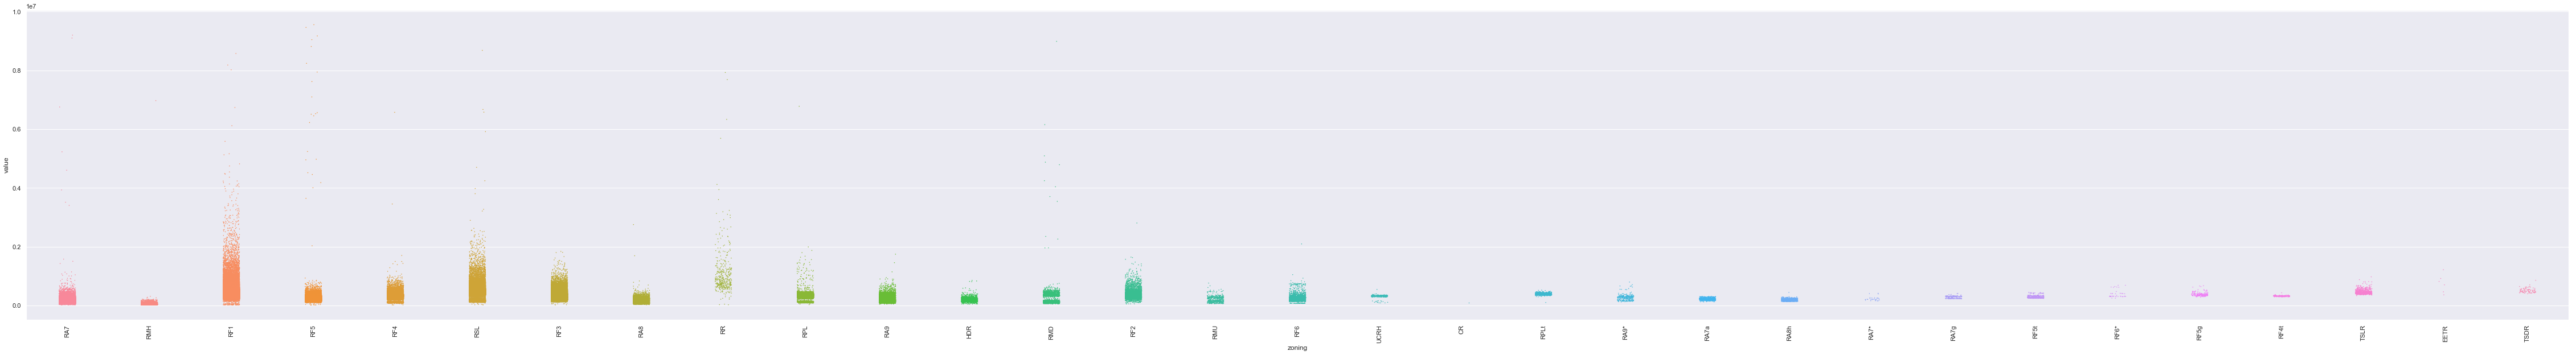

In [13]:
plt.figure(1, figsize=(80,10))

# Overlay a strip plot on the violin plot
sns.stripplot(x='zoning', y='value', data=property_assess, size=1.5, jitter=True)

plt.xticks(rotation=90)

# Display the plot
plt.savefig('zoning values.png')
plt.show()

# Visualization of the Empirical Cumulative Distribution Function of Assessment Values

The following figure is a more statistical representation of the previous histogram. This ECDF shows clearly the 2.5, 25, 50, 75, and 97.5 percentiles for the property assessment values. 

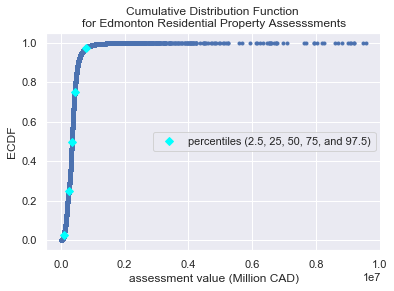

In [14]:
%run stats_func.py

value = property_assess['value']

# Specify array of percentiles: percentiles
percentiles = np.array([2.5, 25, 50, 75, 97.5])

# Compute percentiles
ptiles = np.percentile(value, percentiles)

x_res, y_res = ecdf(value)
_ = plt.plot(x_res, y_res, marker='.', linestyle='none')
_ = plt.xlabel('assessment value (Million CAD)')
_ = plt.ylabel('ECDF')
_ = plt.title('Cumulative Distribution Function \nfor Edmonton Residential Property Assesssments')

_ = plt.plot(ptiles, percentiles/100, marker='D', color='cyan', 
             linestyle='none', label='percentiles (2.5, 25, 50, 75, and 97.5)')
_ = plt.legend(loc='center right')

plt.show()

## Reshaping of DataFrame for Analysis

In [15]:
# In order to make generalizations and visualization on the neighbourhood level
# We group the DataFrame by neighbourhood and aggregate the values by the mean
df_grouped = df_cleaned.groupby(['nb']).mean()

# Drop all mean neighbourhood values except the assessment value
df_grouped = df_grouped[['value']]

In [16]:
# the new neighbourhood assessment means are merged with the crime data
neighbourhood_assess = df_grouped.merge(incidents2018, left_on='nb', right_index=True)

# reset the index of the new DataFrame
nb_assess = neighbourhood_assess.reset_index()

# for crime analysis, remove assessments greater than 4.4 million dollars
nb_assess = nb_assess[nb_assess['value'] < 4400000]

# remove all neighbourhoods that include the name Industrial
# because these primarily do not contain residential properties
df_index = ~nb_assess.nb.str.contains('INDUSTRIAL')
nb_assess = nb_assess[df_index]

# Visualization of Neighbourhood Incident Count by Mean Assessment Value for 8 Crime Indicators

From the figures we can see an intuitive result. The majority of crime happens in areas with the most properties (~$500,000 for an assessment value). Further analysis would be necessary to find a compelling and novel correlation between these 8 crime indicators and mean assessment values. The only figure that does not follow the general trend of the other seven is homicide. This is because neighbourhoods take on a binary classification in regards to homicide; your neighbourhood probably has not had a homicide in 2018 but you may live in one of the 9 neighbourhoods that has had a homicide in 2018. All other crime indicators have a range of incident frequencies.

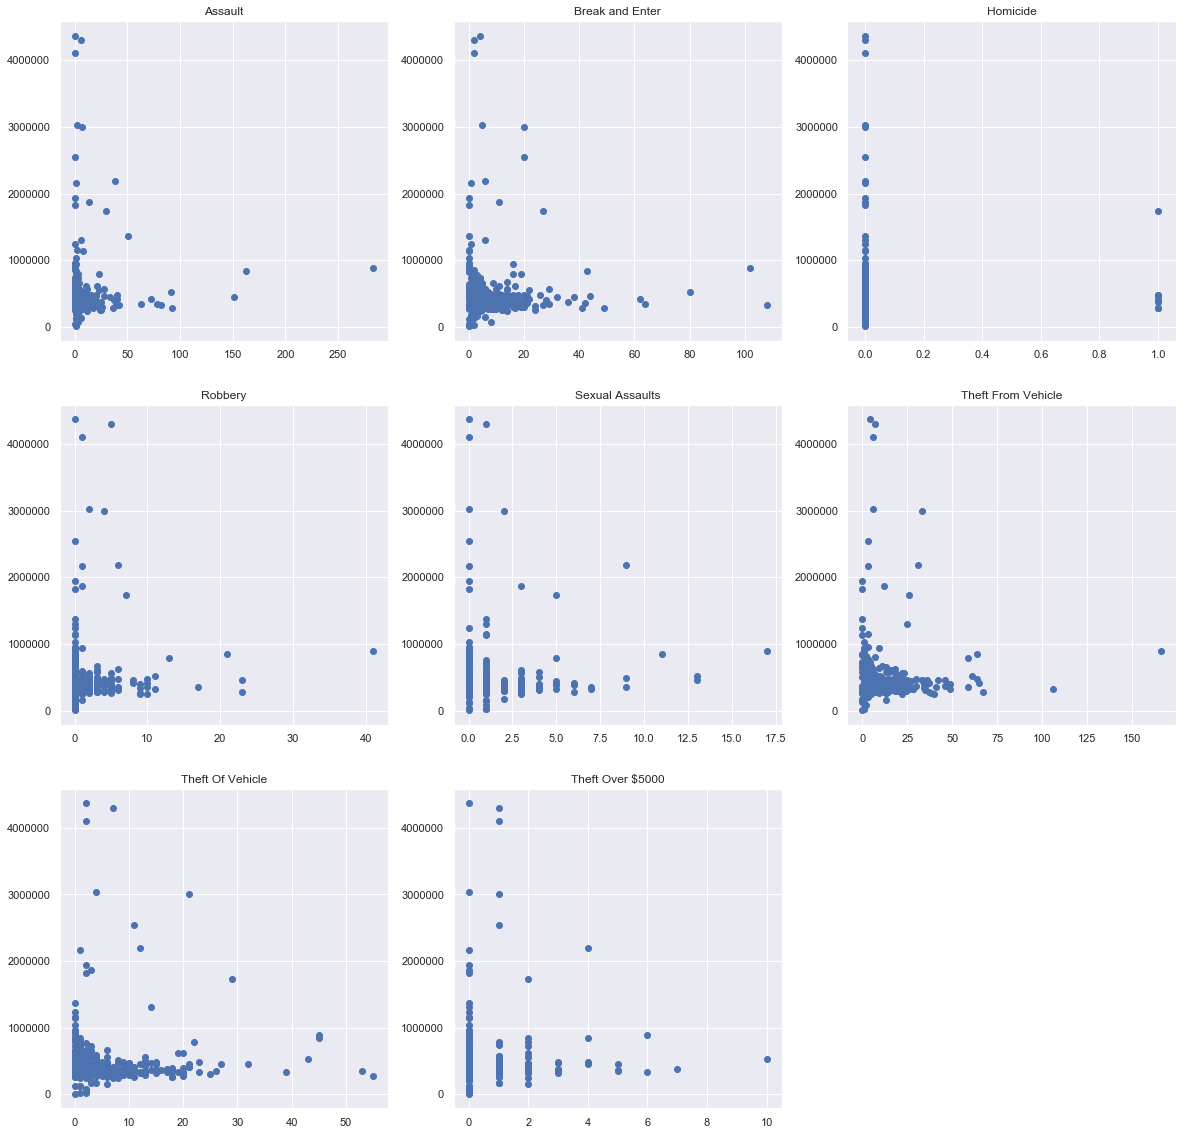

In [17]:
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
plt.scatter(x='Assault', y='value', data=nb_assess)
plt.title('Assault')

plt.subplot(3,3,2)
plt.scatter(x='Break and Enter', y='value', data=nb_assess)
plt.title('Break and Enter')

plt.subplot(3,3,3)
plt.scatter(x='Homicide', y='value', data=nb_assess)
plt.title('Homicide')

plt.subplot(3,3,4)
plt.scatter(x='Robbery', y='value', data=nb_assess)
plt.title('Robbery')

plt.subplot(3,3,5)
plt.scatter(x='Sexual Assaults', y='value', data=nb_assess)
plt.title('Sexual Assaults')

plt.subplot(3,3,6)
plt.scatter(x='Theft From Vehicle', y='value', data=nb_assess)
plt.title('Theft From Vehicle')

plt.subplot(3,3,7)
plt.scatter(x='Theft Of Vehicle', y='value', data=nb_assess)
plt.title('Theft Of Vehicle')

plt.subplot(3,3,8)
plt.scatter(x='Theft Over $5000', y='value', data=nb_assess)
plt.title('Theft Over $5000')

plt.show()

## Example Analysis of Incident Type:

# Function for Generating A Histogram of Crime Incident Frequency

The following function has this docstring:
    
    A function that takes an criminal incident designator,
    (Assault, Break and Enter, Homicide, Robbery, Sexual Assults, Theft From Vehicle,
    Theft Of Vehicle, Theft Over \$5000) and returns a histogram distribution.

The output of the function is the highest frequency of that crime indicator for an Edmonton neighbourhood. Also, the name of the neighbourhood that has the highest frequency. And finally, a histogram that shows the distribution of that crime indicator across all neighbourhooods.

In [18]:
def incident_dist(incident):
    '''A function that takes an criminal incident designator,
    (Assault, Break and Enter, Homicide, Robbery, Sexual Assults, Theft From Vehicle,
    Theft Of Vehicle, Theft Over $5000) and returns a histogram distribution.
    '''
    
    print('The maximum number of ' + incident + ' for any neighbourhood in Edmonton 2018 is: \n' 
          + str(nb_assess[incident].max()))
    print('\nThe neighbourhood with the most ' + incident + ' in 2018 is/are: \n' 
          + str(nb_assess[nb_assess[incident] == nb_assess[incident].max()].nb))
    
    ax = nb_assess[incident].plot(kind='hist',range=(0,nb_assess[incident].max()), bins=100, title=incident)
    ax.set_ylabel('Number of Neighbourhoods')
    ax.set_xlabel('Number of Incidents in 2018')
plt.show()

The maximum number of Homicide for any neighbourhood in Edmonton 2018 is: 
1

The neighbourhood with the most Homicide in 2018 is/are: 
2         ALBERTA AVENUE
32             BELVEDERE
56     CALLINGWOOD SOUTH
157             HOLYROOD
163            INGLEWOOD
168             KEHEEWIN
174              KILDARE
283            ROSENTHAL
305        SPRUCE AVENUE
Name: nb, dtype: category
Categories (395, object): [ABBOTTSFIELD, ALBANY, ALBERTA AVENUE, ALBERTA PARK INDUSTRIAL, ..., MILL WOODS PARK, RIVER VALLEY LAURIER, RIVER VALLEY LESSARD NORTH, GLENRIDDING RAVINE]


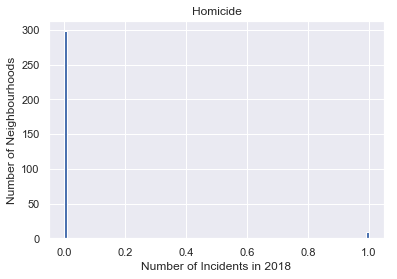

In [19]:
incident_dist('Homicide')

# [Historical Assessment Values 2012-2017](https://data.edmonton.ca/City-Administration/Property-Assessment-Data-2012-2017-/qi6a-xuwt)
- Even though the dataset is significantly large, there is no requirement for a chunking method when loading the csv locally.

In [20]:
# set column names that are intuitive, standardized, and callable as DataFrame attributes
col_names = ['acc_num', 'lot_size', 'year', 'suite', 'number', 'street', 
             'legal_land', 'garage', 'nb', 'value', 'class', 'year_built', 'zoning']

# set column datatypes
col_dtypes = {'acc_num':np.int32, 'lot_size':np.float32, 'year':np.int32, 
              'suite':object, 'number':object, 'street':object, 
              'value':np.int32, 'class':'category', 'nb':'category'}

# set the column order
col_keep = ['acc_num', 'lot_size', 'year', 'suite', 'number', 'street', 
            'garage', 'nb', 'value', 'class', 'year_built', 'zoning']

# import the csv data into a DataFrame: df_history
df_history = pd.read_csv('Property_Assessment_Data__2012_-_2017.csv', 
                 header=0, names=col_names, dtype=col_dtypes, 
                 true_values='Y', false_values='N')

In [21]:
# sort the DataFrame by year
df_history = df_history.sort_values(by='year')

# fill the missing zoning data with an empty string
df_history['zoning'] = df_history['zoning'].fillna('')

# filter the DataFrame for zones that contain R
df_index = df_history.zoning.str.contains('R')
df_history = df_history[df_index]

# filter the DataFrame for only the Residential class
df_history = df_history[df_history['class'] == 'Residential']

# filter the DataFrame for only values between $20,000 to $10,000,000
df_history = df_history[df_history['value'] > 20000]
df_history = df_history[df_history['value'] < 10000000]

# filter the DataFrame to exclude neighbourhoods with Industrial in the name
df_index = ~df_history.nb.str.contains('INDUSTRIAL')
df_history = df_history[df_index]

In [22]:
# pivot the DataFrame to represent the median assessment value for each neighbourhood,
# organized by year
history_pivot = df_history.pivot_table(values='value', index='year', 
                                       columns='nb', aggfunc='median')

# [Population Data from 2016 Census](https://data.edmonton.ca/Census/2016-Census-Population-by-Citizenship-Neighbourhoo/2g4b-ti2n)

In [23]:
# set the name/path for the csv
citizenship = '2016_Census_-_Population_by_Citizenship__Neighbourhood_Ward_.csv'

# read the csv into a DataFrame: df_cit
df_cit = pd.read_csv(citizenship)

# generate a column 'sum' which is the sum of all the citizenship category populations
df_cit['sum'] = df_cit['Canadian Citizen'] + df_cit['Permanent Resident'] + df_cit['Refugee'] + df_cit['Other'] + df_cit['No Response']

# extract the the neighbourhood and the sum as a DataFrame: df_pop
df_pop = df_cit.loc[:, ['Neighbourhood Name', 'sum']]

# rename the columns
df_pop.columns = ['nb', 'population']

# set the index as the neighbourhood
df_pop = df_pop.set_index('nb')

# sort the DataFrame by population
df_pop.sort_values(by='population', inplace=True)

# exclude all neighbourhoods that did not have 2016 population values
# these are primarily industrial, fully commercial, or newly created neighbourhoods
df_pop = df_pop[106:]

In [24]:
# set the index of nb_assess to the neighbourhood in a new DataFrame: nb
nb = nb_assess.set_index('nb')

# drop the original index
nb = nb.iloc[:, 1:]

In [25]:
# merge the DataFrames nb and df_pop
nb_pop_assess = nb.merge(df_pop, how='left', left_index=True, right_index=True)

# generate a column 'num_incidents' which is the sum of all 8 crime indicators 
# for a neighbourhood
nb_pop_assess['num_incidents'] = nb_pop_assess['Assault'] + nb_pop_assess['Break and Enter'] + nb_pop_assess['Homicide'] + nb_pop_assess['Robbery'] + nb_pop_assess['Sexual Assaults'] + nb_pop_assess['Theft From Vehicle'] + nb_pop_assess['Theft Of Vehicle'] + nb_pop_assess['Theft Over $5000']

# calculate the crime per capita by dividing the number of incidents by the population
# for a neighbourhood
nb_pop_assess['crime_per_capita'] = nb_pop_assess['num_incidents'] / nb_pop_assess['population']

# view the output for the first 5 neighbourhoods
nb_pop_assess.head()

,Assault,Break and Enter,Homicide,Robbery,Sexual Assaults,Theft From Vehicle,Theft Of Vehicle,Theft Over $5000,population,num_incidents,crime_per_capita
nb,,,,,,,,,,,
ABBOTTSFIELD,14,2,0,3,1,10,6,0,1907.0,36,0.018878
ALBANY,4,5,0,1,0,7,5,0,1283.0,22,0.017147
ALBERTA AVENUE,92,41,1,23,6,67,55,0,6755.0,285,0.042191
ALDERGROVE,12,18,0,2,3,12,10,0,4980.0,57,0.011446
ALLARD,1,9,0,0,0,13,4,1,3133.0,28,0.008937


# Visualization of the Number of Crimial Incidents by Neighbourhood Population

The following figure is labelled to show the neighbourhood that fall furthest from the trendline. In some cases this is positive (Summerside) and others more alarming (Downtown, Central McDougall, Boyle Street, McCauley). Oliver is labelled to show that this is not an outlier; Oliver is simply the most populated neighbourhood that has a crime frequency that falls reasonably close to the trendline.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


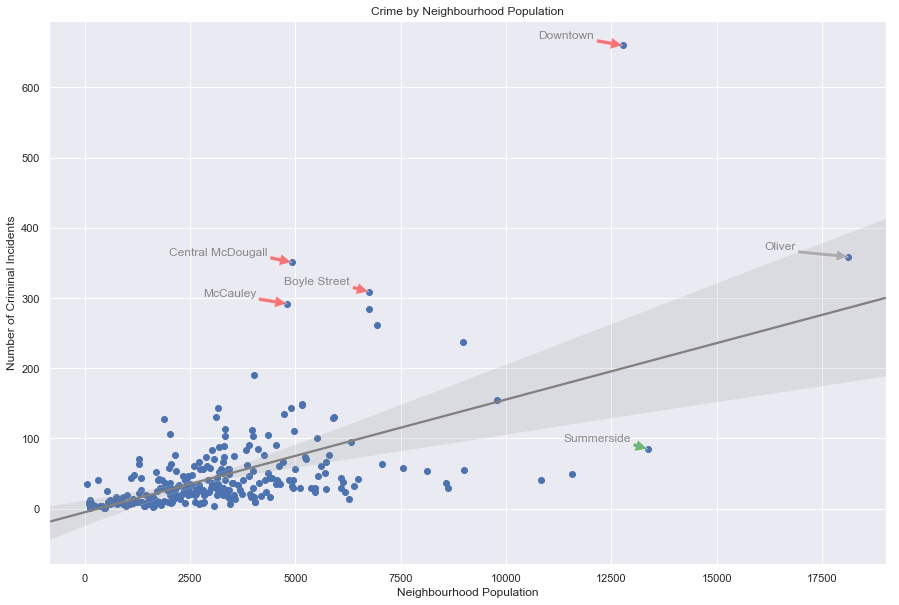

In [26]:
pop = nb_pop_assess['population']
inc = nb_pop_assess['num_incidents']

plt.figure(figsize=(15,10))

plt.scatter(pop, inc)

# Add arrow annotation
plt.annotate('Downtown', xy=(12768, 660), xytext=(10768, 660+10), arrowprops=dict(facecolor='red', alpha=0.5), alpha=0.5)
plt.annotate('Oliver', xy=(18123, 359), xytext=(16123, 359+10), arrowprops=dict(facecolor='gray', alpha=0.5), alpha=0.5)
plt.annotate('Central McDougall', xy=(4911, 351), xytext=(2000, 351+10), arrowprops=dict(facecolor='red', alpha=0.5), alpha=0.5)
plt.annotate('Boyle Street', xy=(6740, 309), xytext=(4740, 309+10), arrowprops=dict(facecolor='red', alpha=0.5), alpha=0.5)
plt.annotate('McCauley', xy=(4799, 292), xytext=(2799, 292+10), arrowprops=dict(facecolor='red', alpha=0.5), alpha=0.5)
plt.annotate('Summerside', xy=(13360, 85), xytext=(11360, 85+10), arrowprops=dict(facecolor='green', alpha=0.5), alpha=0.5)

sns.regplot(x='population', y='num_incidents', data=nb_pop_assess, color='grey', scatter=None, order=1)


# Add axis labels and title
plt.xlabel('Neighbourhood Population')
plt.ylabel('Number of Criminal Incidents')
plt.title('Crime by Neighbourhood Population')

plt.savefig('crime_population.png')

plt.show()

# Visualization of the Linear Least Squares Residuals for Population vs Crime Incidents

The least squares residuals shows that there is significantly more variability in the number of crimes commited in more populated neighbourhoods.

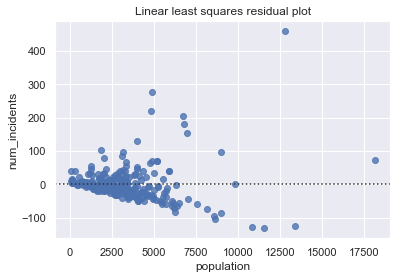

In [27]:
_ = sns.residplot(x='population', y='num_incidents', data=nb_pop_assess, order=1)
_ = plt.title('Linear least squares residual plot')
plt.show()

# Function Analysis of a Neighbourhood

The docstring for the following function is:

    This function takes a string input for an Edmonton neighbourhood
    and returns the criminal incidents, median property value change, and an
    indication of where your neighbourhood resides in a crime per capita scatterplot.
    
This function is a great visual starting point for analysis of a particular neighbourhood in Edmonton

In [28]:
def my_neighbourhood(neighbourhood):
    '''This function takes a string input for an Edmonton neighbourhood
    and returns the criminal incidents, median property value change, and an
    indication of where your neighbourhood resides in a crime per capita scatterplot.
    '''
    
    neighbourhood = str(neighbourhood).upper()
    
    n_pop = df_pop.loc[neighbourhood, 'population']
    
    print('The reported crimes in 2018 for ' + neighbourhood + ' (2016 population: ' + str(n_pop) + ')\nare given by the following figure:')
    
    my_n = nb.loc[neighbourhood]
    plt.figure(figsize=(10,5))
    ax = my_n.plot(kind='barh', color='gray', title=neighbourhood + ' Criminal Incidents')
    ax.set_ylabel('Number of Crimes Reported in 2018')
    ax.xaxis.grid(True, which='major', color='w')
    plt.show()
    
    plt.clf
    
    print('The median property value change for ' + neighbourhood + '\nis given by the following figure:')
    
    plt.figure(figsize=(11,5))
    ax = history_pivot[neighbourhood].plot(color='grey', title=neighbourhood + ' Median Property Value Change', marker='.')
    ax.set_ylabel('Property Assessed Value')
    ax.set_xlabel('Year')
    ax.yaxis.grid(True, which='major', color='grey', alpha=0.2)
    plt.show()

    plt.clf
    
    pop = nb_pop_assess['population']
    inc = nb_pop_assess['num_incidents']
    x = nb_pop_assess.loc[neighbourhood, 'population']
    y = nb_pop_assess.loc[neighbourhood, 'num_incidents']
    plt.figure(figsize=(12,5))
    plt.scatter(pop, inc)
    plt.annotate(neighbourhood, xy=(x,y), xytext=(5000, 600), arrowprops=dict(facecolor='white', alpha=0.5), alpha=0.5)
    sns.regplot(x='population', y='num_incidents', data=nb_pop_assess, color='grey', scatter=None, order=1)

    plt.xlabel('Neighbourhood Population (2016)')
    plt.ylabel('Number of Criminal Incidents (2018)')
    plt.title('Crime (2018) by Neighbourhood Population (2016)')
    plt.show()

The reported crimes in 2018 for STARLING (2016 population: 654)
are given by the following figure:


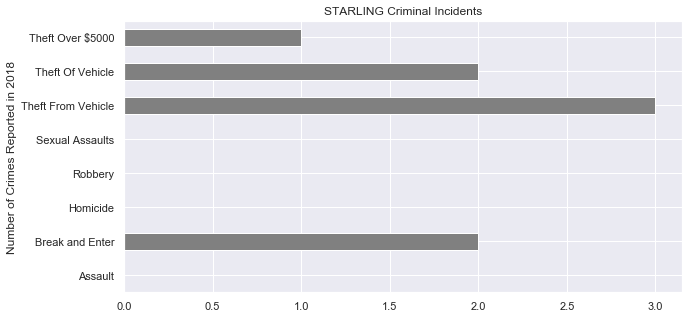

The median property value change for STARLING
is given by the following figure:


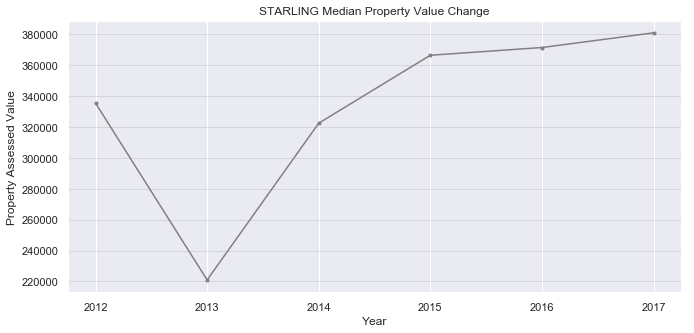

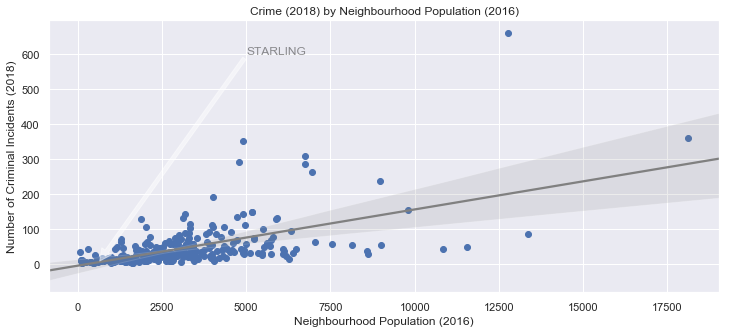

In [29]:
my_neighbourhood('STARLING')

In [30]:
df_capita_crime = df_clean.merge(nb_pop_assess, left_on='nb', right_index=True)

df_capita_crime.to_csv('assessment_per_capita.csv')

In [31]:
df_capita_crime.sort_values(by=['crime_per_capita', 'value'])
capita_crime = df_capita_crime.dropna(subset=['population', 'crime_per_capita'])

In [32]:
value = np.array(capita_crime['value'][:-15])
crime = np.array(capita_crime['crime_per_capita'][:-15] * 100)

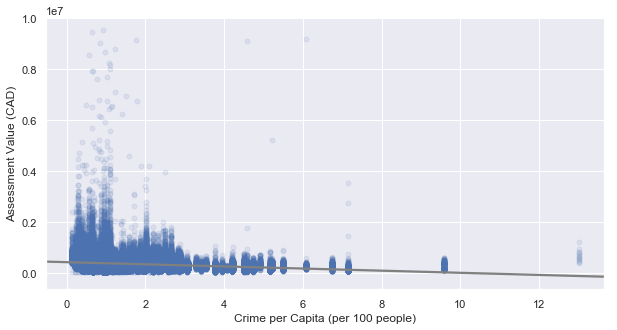

In [41]:
_ = plt.figure(figsize=(10,5))
_ = plt.plot(crime, value, marker='.', linestyle='none', alpha=0.1, markersize=10)
_ = plt.xlabel('Crime per Capita (per 100 people)')
_ = plt.ylabel('Assessment Value (CAD)')

sns.regplot(x=crime, y=value, color='grey', scatter=None, order=1)

plt.show()

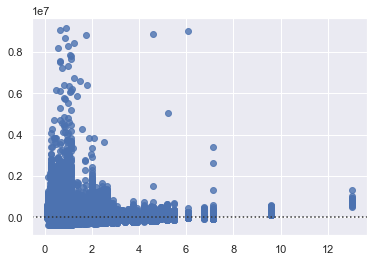

In [34]:
_ = sns.residplot(x=crime, y=value, order=1)

plt.show()

# Hypothesis Testing
## Does having a garage affect your property assessment?

In [35]:
df_garage = df_clean[df_clean['garage'] == True]
df_no_garage = df_clean[~df_clean['garage'] == True]
print('with garage mean assessment:', np.mean(df_garage.value), '\nno garage mean assessment:', np.mean(df_no_garage.value))
print('with garage assessment standard deviation:', np.std(df_garage.value), '\nno garage assessment standard deviation:', np.std(df_no_garage.value))

with garage mean assessment: 430575.3893830812 
no garage mean assessment: 207761.48337595907
with garage assessment standard deviation: 197672.30372608424 
no garage assessment standard deviation: 177406.09280880945


In [36]:
std_mean_diff = np.sqrt(np.std(df_garage.value) ** 2 / len(df_garage.value) + np.std(df_no_garage.value) ** 2 / len(df_no_garage.value))
std_mean_diff

736.4367936160216

In [37]:
observed_mean_diff = np.mean(df_garage.value) - np.mean(df_no_garage.value)
observed_mean_diff

222813.9060071221

### Confidence Interval

In [38]:
conf_int = std_mean_diff * 2.58

In [39]:
print('We are 99% confident that the true difference of means lies between:', observed_mean_diff - conf_int, 'and', observed_mean_diff + conf_int)

We are 99% confident that the true difference of means lies between: 220913.89907959275 and 224713.91293465145


### Hypothesis Test
Ho: Having a garage does not affect your property assessment value (`μ garage` - `μ no garage` = 0)
Ha: Having a garage increases your property assessment value (`μ garage` - `μ no garage` > 0)
α = 0.01

In [40]:
critical_z = 2.33
critical_value = std_mean_diff * critical_z
critical_value

1715.8977291253304

If we assume that the null hypothesis is true, there is only a 1% chance that we see a mean difference (between assessments with garages and those without) greater than 1,715.90 CAD. Our observed difference is 222,813.91 CAD and we therefore reject the null hypothesis for the alternative. The mean assessed value of properties with garages are significantly higher than those without garages.